In [1]:

import requests
import pandas as pd
from neuralforecast import NeuralForecast
from neuralforecast.models import LSTM, NHITS
import matplotlib.pyplot as plt

# Fetch data from the API for training (1 year) and testing (1 month)
url_train = "https://api.energy-charts.info/price?bzn=DE-LU&start=2024-01-01&end=2024-09-01"
url_test = "https://api.energy-charts.info/price?bzn=DE-LU&start=2024-09-01&end=2024-10-01"

response_train = requests.get(url_train)
response_test = requests.get(url_test)

data_train = response_train.json()
data_test = response_test.json()

# Convert to DataFrame
train_df = pd.DataFrame({
    'timestamp': pd.to_datetime(data_train['unix_seconds'], unit='s'),
    'price': data_train['price']
})
test_df = pd.DataFrame({
    'timestamp': pd.to_datetime(data_test['unix_seconds'], unit='s'),
    'price': data_test['price']
})

# Clean the data (remove rows with null prices)
train_df = train_df.dropna()
test_df = test_df.dropna()

# Rename columns for NeuralForecast
train_df = train_df.rename(columns={'timestamp': 'ds', 'price': 'y'})
test_df = test_df.rename(columns={'timestamp': 'ds', 'price': 'y'})
train_df['unique_id'] = 'electricity_prices'
test_df['unique_id'] = 'electricity_prices'

# Check date ranges
print("Last date in train_df:", train_df['ds'].max())
print("First date in test_df:", test_df['ds'].min())



/Users/i744722/opt/anaconda3/envs/machine_learning_test/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-11-06 22:48:26,300	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
2024-11-06 22:48:26,737	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


Last date in train_df: 2024-09-01 21:00:00
First date in test_df: 2024-08-31 22:00:00


In [4]:
# Forecasting with NeuralForecast
horizon = len(test_df)

models = [
    LSTM(h=horizon, max_steps=100, scaler_type='standard', encoder_hidden_size=64, decoder_hidden_size=64),
    NHITS(h=horizon, input_size=2 * horizon, max_steps=100, n_freq_downsample=[2, 1, 1])
]

nf = NeuralForecast(models=models, freq='M')
nf.fit(df=train_df)


Seed set to 1
Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type          | Params | Mode 
----------------------------------------------------------
0 | loss            | MAE           | 0      | train
1 | padder          | ConstantPad1d | 0      | train
2 | scaler          | TemporalNorm  | 0      | train
3 | hist_encoder    | LSTM          | 50.4 K | train
4 | context_adapter | Linear        | 483 K  | train
5 | mlp_decoder     | MLP           | 769    | train
----------------------------------------------------------
534 K     Trainable params
0         Non-trainable params
534 K     Total params
2.139     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00,  1.59it/s, v_num=46, train_loss_step=0.578, train_loss_epoch=0.577]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 99: 100%|██████████| 1/1 [00:00<00:00,  1.57it/s, v_num=46, train_loss_step=0.578, train_loss_epoch=0.578]

`Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00,  1.57it/s, v_num=46, train_loss_step=0.578, train_loss_epoch=0.578]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAE           | 0      | train
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler       | TemporalNorm  | 0      | train
3 | blocks       | ModuleList    | 7.1 M  | train
-------------------------------------------------------
7.1 M     Trainable params
0         Non-trainable params
7.1 M     Total params
28.533    Total estimated model params size (MB)
34        Modules in train mode
0         Modules in eval mode



Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 13.46it/s, v_num=47, train_loss_step=24.40, train_loss_epoch=24.40]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 12.26it/s, v_num=47, train_loss_step=24.40, train_loss_epoch=24.40]

`Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 12.02it/s, v_num=47, train_loss_step=24.40, train_loss_epoch=24.40]


In [5]:

# Get predictions
Y_hat_df = nf.predict(df=test_df[['unique_id', 'ds', 'y']])
Y_hat_df = Y_hat_df.reset_index()

# Check prediction date range
print("First date in Y_hat_df:", Y_hat_df['ds'].min())
print("Last date in Y_hat_df:", Y_hat_df['ds'].max())


Y_hat_df.head(50)

/Users/i744722/opt/anaconda3/envs/machine_learning_test/lib/python3.11/site-packages/utilsforecast/processing.py:384: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
/Users/i744722/opt/anaconda3/envs/machine_learning_test/lib/python3.11/site-packages/utilsforecast/processing.py:438: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  5.17it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  4.12it/s]
First date in Y_hat_df: 2024-10-31 21:00:00
Last date in Y_hat_df: 2086-09-30 21:00:00


/Users/i744722/opt/anaconda3/envs/machine_learning_test/lib/python3.11/site-packages/neuralforecast/core.py:210: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(


,unique_id,ds,LSTM,NHITS
0,electricity_prices,2024-10-31 21:00:00,84.597725,74.246071
1,electricity_prices,2024-11-30 21:00:00,83.500984,67.318008
2,electricity_prices,2024-12-31 21:00:00,83.665886,62.307777
3,electricity_prices,2025-01-31 21:00:00,79.308205,62.808128
4,electricity_prices,2025-02-28 21:00:00,83.736633,68.144562
5,electricity_prices,2025-03-31 21:00:00,83.946320,78.675331
6,electricity_prices,2025-04-30 21:00:00,89.397118,82.546738
7,electricity_prices,2025-05-31 21:00:00,81.857727,89.707565
8,electricity_prices,2025-06-30 21:00:00,82.935974,80.906265
9,electricity_prices,2025-07-31 21:00:00,78.050583,67.371605


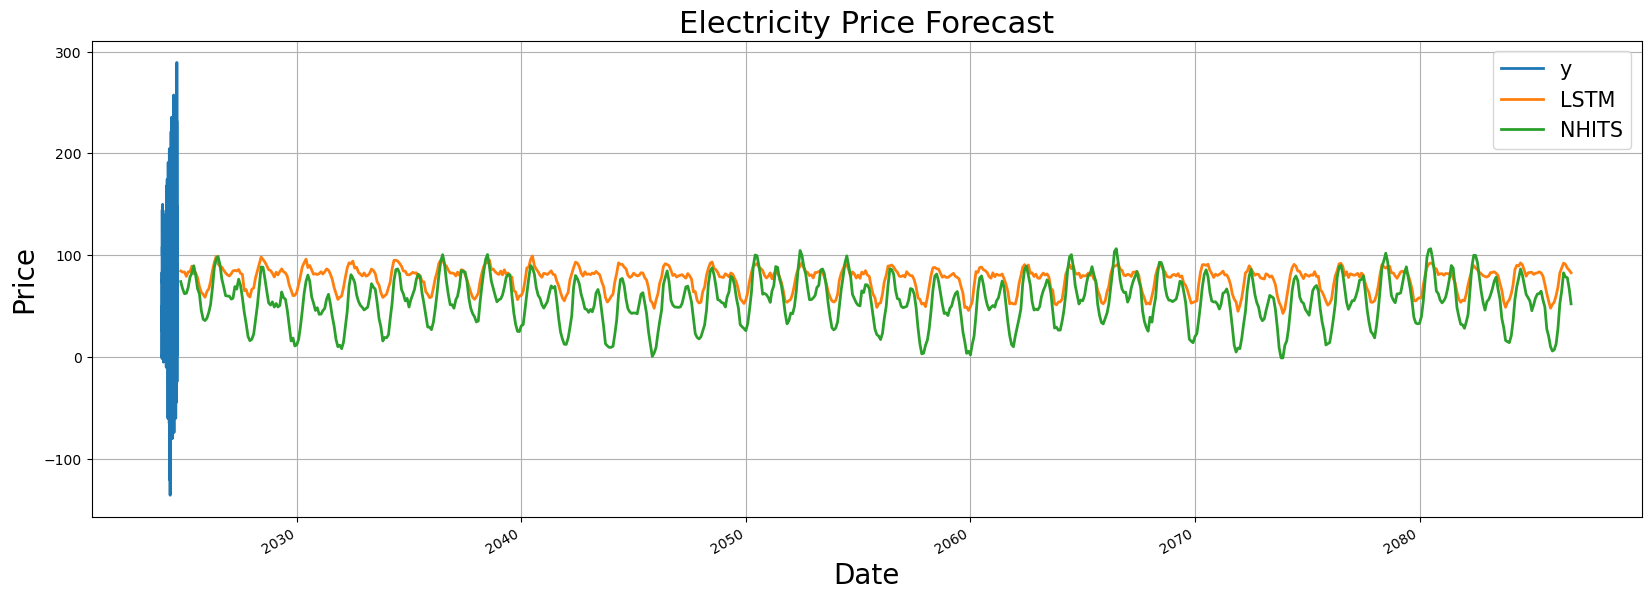

In [6]:
# Plotting
plot_df = pd.concat([train_df[['ds', 'y']], Y_hat_df[['ds', 'LSTM', 'NHITS']]]).set_index('ds')

fig, ax = plt.subplots(1, 1, figsize=(20, 7))
plot_df[['y', 'LSTM', 'NHITS']].plot(ax=ax, linewidth=2)

ax.set_title('Electricity Price Forecast', fontsize=22)
ax.set_ylabel('Price', fontsize=20)
ax.set_xlabel('Date', fontsize=20)
ax.legend(prop={'size': 15})
ax.grid()
plt.show()